In [1]:
import numpy as np
np.random.seed(2023)
import random
random.seed(2023)
print('[INFO] Using numpy {0}'.format(np.__version__))

import sklearn
#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
print('[INFO] Using sklearn {0}'.format(sklearn.__version__))

import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

# ______________________________________________________________________________
# Globals
nlayers = 25  # 13 (CSC) + 9 (RPC) + 3 (GEM)

#infile = '../test2/histos_tba.8.npz'
#infile = '../test2/histos_tba.9.npz'
#infile = '../test2/histos_tba.10.npz'
#infile = '../test2/histos_tba_2GeV.10.npz'
infile = '../test2/histos_tba_2GeV.11.npz'

#chsqfile = '../test2/chsq.10.npz'
#chsqfile = 'chsq.npz'
chsqfile = 'chsq_2GeV.npz'


[INFO] Using numpy 1.12.1
[INFO] Using sklearn 0.18.1


In [2]:
#### Load data ####

try:
    loaded = np.load(infile)
    the_parameters = loaded['parameters']
    the_variables = loaded['variables']
except:
    print('[ERROR] Failed to load data from file: {0}'.format(infile))

print('[INFO] Loaded the variables with shape {0}'.format(the_variables.shape))
print('[INFO] Loaded the parameters with shape {0}'.format(the_parameters.shape))

[INFO] Loaded the variables with shape (3144189, 104)
[INFO] Loaded the parameters with shape (3144189, 3)


In [3]:
class Encoder(object):

  def __init__(self, x, y, adjust_scale=0):
    if x is not None and y is not None:
      assert(x.shape[1] == (nlayers * 4) + 4)
      assert(y.shape[1] == 3)
      assert(x.shape[0] == y.shape[0])

      self.nentries = x.shape[0]
      self.x_orig  = x
      self.y_orig  = y
      self.x_copy  = x.copy()
      self.y_copy  = y.copy()

      # Get views
      self.x_phi   = self.x_copy[:, nlayers*0:nlayers*1]
      self.x_theta = self.x_copy[:, nlayers*1:nlayers*2]
      self.x_bend  = self.x_copy[:, nlayers*2:nlayers*3]
      self.x_mask  = self.x_copy[:, nlayers*3:nlayers*4].astype(np.bool)  # this makes a copy
      self.x_road  = self.x_copy[:, nlayers*4:nlayers*5]  # ipt, ieta, iphi, iphi_corr
      self.y_pt    = self.y_copy[:, 0]  # q/pT
      self.y_phi   = self.y_copy[:, 1]
      self.y_eta   = self.y_copy[:, 2]
      
      # Make event weight
      #self.w       = np.ones(self.y_pt.shape, dtype=np.float32)
      self.w       = np.abs(self.y_pt)/0.2 + 1.0
      
      # Subtract median phi from hit phis
      #self.x_phi_median    = self.x_road[:, 2] * 32 - 16  # multiply by 'quadstrip' unit (4 * 8)
      self.x_phi_median    = self.x_road[:, 2] * 16 - 8  # multiply by 'doublestrip' unit (2 * 8)
      self.x_phi_median    = self.x_phi_median[:, np.newaxis]
      self.x_phi          -= self.x_phi_median
      
      # Subtract median theta from hit thetas
      self.x_theta_median  = np.nanmedian(self.x_theta[:,:13], axis=1)  # CSC only
      self.x_theta_median[np.isnan(self.x_theta_median)] = np.nanmedian(self.x_theta[np.isnan(self.x_theta_median)], axis=1)  # use all
      self.x_theta_median  = self.x_theta_median[:, np.newaxis]
      self.x_theta        -= self.x_theta_median
      
      # Zones
      self.x_ieta  = self.x_road[:, 1].astype(np.int32)
      
      # Standard scales
      if adjust_scale == 0:  # do not adjust
        pass
      elif adjust_scale == 1:  # use mean and std
        self.x_mean  = np.nanmean(self.x_copy, axis=0)
        self.x_std   = np.nanstd(self.x_copy, axis=0)
        self.x_std   = self._handle_zero_in_scale(self.x_std)
        self.x_copy -= self.x_mean
        self.x_copy /= self.x_std
      elif adjust_scale == 2:  # use covariance
        with np.load(chsqfile) as loaded:
          self.x_cov = loaded['cov']
        nvariables_to_scale = self.x_cov.size
        self.x_copy[:, :nvariables_to_scale] *= self.x_cov
      
      # Remove outlier hits by checking hit thetas
      if adjust_scale == 0:  # do not adjust
        x_theta_tmp = np.abs(self.x_theta) > 10000.0
      else:
        x_theta_tmp = np.abs(self.x_theta) > 1.0
      self.x_phi  [x_theta_tmp] = np.nan
      self.x_theta[x_theta_tmp] = np.nan
      self.x_bend [x_theta_tmp] = np.nan
      self.x_mask [x_theta_tmp] = 1.0
      
      # Remove all RPC hits
      bad_rpcs = np.array((0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0), dtype=np.bool)
      assert(len(bad_rpcs) == nlayers)
      self.x_phi  [:, bad_rpcs] = np.nan
      self.x_theta[:, bad_rpcs] = np.nan
      self.x_bend [:, bad_rpcs] = np.nan
      self.x_mask [:, bad_rpcs] = 1.0
      
      # Add variables: theta_median and mode variables
      self.x_theta_median -= 3.  # scaled to [0,1]
      self.x_theta_median /= 83.
      hits_to_station = np.array((5,5,1,1,1,2,2,2,2,3,3,4,4,1,1,2,3,3,3,4,4,4,5,2,5), dtype=np.int32)  # '5' denotes ME1/1
      assert(len(hits_to_station) == nlayers)
      self.x_mode_vars = np.zeros((self.nentries, 5), dtype=np.float32)
      self.x_mode_vars[:,0] = np.any(self.x_mask[:,hits_to_station == 5] == 0, axis=1)
      self.x_mode_vars[:,1] = np.any(self.x_mask[:,hits_to_station == 1] == 0, axis=1)
      self.x_mode_vars[:,2] = np.any(self.x_mask[:,hits_to_station == 2] == 0, axis=1)
      self.x_mode_vars[:,3] = np.any(self.x_mask[:,hits_to_station == 3] == 0, axis=1)
      self.x_mode_vars[:,4] = np.any(self.x_mask[:,hits_to_station == 4] == 0, axis=1)
      
      # Remove NaN
      #np.nan_to_num(self.x_copy, copy=False)
      self.x_copy[np.isnan(self.x_copy)] = 0.0

  # Copied from scikit-learn
  def _handle_zero_in_scale(self, scale):
    scale[scale == 0.0] = 1.0
    return scale

  def get_x(self):
    #x_new = self.x_phi
    x_new = np.hstack((self.x_phi, self.x_theta, self.x_bend, self.x_theta_median, self.x_mode_vars))
    return x_new

  def get_x_mask(self):
    x_mask = self.x_mask.copy()
    return x_mask

  def get_x_ieta(self):
    x_ieta = self.x_ieta.copy()
    return x_ieta

  def get_y(self):
    y_new = self.y_pt.copy()
    return y_new

  def get_w(self):
    w_new = self.w.copy()
    return w_new

  def save_encoder(self, filepath):
    np.savez_compressed(filepath, x_mean=self.x_mean, x_std=self.x_std)

  def load_endcoder(self, filepath):
    loaded = np.load(filepath)
    self.x_mean = loaded['x_mean']
    self.x_std = loaded['x_std']


In [4]:
#### Prepare data ####

# Preprocess data
encoder = Encoder(the_variables, the_parameters, adjust_scale=0)
x, y, w, x_mask = encoder.get_x(), encoder.get_y(), encoder.get_w(), encoder.get_x_mask()
#encoder.save_encoder('encoder.npz')
#print('[INFO] Encoder is saved as encoder.npz')

# 1/pT -> 1/pT * sinh(1.8) / sinh(eta)
y *= (np.sinh(1.8) / np.sinh(encoder.y_eta))

# Split dataset in training and testing
x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test = train_test_split(x, y, w, x_mask, test_size=0.4)

nvariables = x_train.shape[1]
nparameters = 1
print('[INFO] Using {0} variables and {1} parameters'.format(nvariables, nparameters))

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-numpy/1.12.1-mlhled2/lib/python2.7/site-packages/numpy-1.12.1-py2.7-linux-x86_64.egg/numpy/lib/function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/5.0-ghjeda6/lib/python2.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in greater


[INFO] Using 81 variables and 1 parameters


In [5]:
print x, y, w
print np.mean(x, axis=0)
print np.std(x, axis=0)
print np.isfinite(x).all()

[[   0.    0.    0. ...,    1.    0.    1.]
 [   0.  186.    0. ...,    1.    1.    0.]
 [   0.    0.  107. ...,    1.    0.    1.]
 ..., 
 [   0. -159.    0. ...,    1.    1.    1.]
 [ 228.    0.    0. ...,    1.    1.    1.]
 [   0.   97.    0. ...,    1.    1.    1.]] [ 0.00514998  0.24846926  0.3417066  ..., -0.19517438  0.25752071
  0.08966849] [ 1.04175162  2.16192913  2.0318923  ...,  1.79922843  2.67522669
  1.58791852]
[ -6.71676874e-01  -8.40744317e-01  -3.02261412e-01  -3.17981839e-01
   0.00000000e+00  -6.27965450e-01  -7.11638510e-01  -2.46957481e-01
  -2.96422064e-01  -1.19727409e+00  -6.87494934e-01  -9.62142527e-01
  -8.18057358e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.23133433e+00  -9.88423705e-01
   0.00000000e+00   3.72771174e-01   3.27605933e-01   1.69208497e-01
   1.02247991e-01   0.00000000e+00   1.42278348e-03  -6.14657719e-03
   1.96118932e-0

In [6]:
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor
from sklearn.covariance import EmpiricalCovariance, MinCovDet

class ChiSquare(object):
  
  def __init__(self, x, x_mask, y):
    
    self.nentries = 40000 * 3
    self.nvariables = (nlayers*3)
    
    self.x = x[:self.nentries, :self.nvariables]
    self.x_mask = x_mask[:self.nentries]
    self.y = y[:self.nentries]
    
    self.cov = np.ones(self.nvariables, dtype=np.float32)   # mcd
    self.cov_1 = np.ones(self.nvariables, dtype=np.float32) # lr
    self.cov_2 = np.ones(self.nvariables, dtype=np.float32) # ridge
    self.cov_3 = np.ones(self.nvariables, dtype=np.float32) # huber
    self._find_covariance()

  def _find_covariance(self):
    for i in xrange(self.nvariables):
      print('[INFO] Find covariance for var {0}'.format(i))

      lay = (i % nlayers)
      valid = ~self.x_mask[:,lay]
      
      if i in [5, 6, 7, 8, 15, 23]:  # ME2/1f, ME2/1r, ME2/2f, ME2/2r, RE2/2, GE2/1
        valid = valid & ((self.y < -1.0/14) | (self.y > +1.0/14))  # skip high pT part (>14 GeV)
      
      x_i = self.x[:,i][valid]
      y_i = self.y[valid]
      #print x_i, y_i

      if x_i.size == 0:
        continue
      if x_i.size < 400:
        print('[WARNING] Not enough statistics: {0}'.format(x_i.size))

      x_mean = np.mean(x_i)
      #x_i -= x_mean

      x_std = np.std(x_i)
      if x_std == 0.0:
        continue

      # x_phi
      if (i < nlayers):
        # http://scikit-learn.org/stable/modules/generated/sklearn.covariance.MinCovDet.html
        # Minimum Covariance Determinant (MCD): robust estimator of covariance.
        mcd = MinCovDet(assume_centered=True).fit(np.column_stack((x_i,y_i)))
        coef = mcd.covariance_[0,1] / mcd.covariance_[0,0]
        self.cov[i] = coef
        #print coef, mcd.covariance_
        print coef

        # Check with simple linear regression y = a * x
        lr = LinearRegression(fit_intercept=False).fit(x_i[:,np.newaxis], y_i)
        coef = lr.coef_[0]
        self.cov_1[i] = coef
        print coef
        
        # Check with Ridge regression
        ridge = Ridge(fit_intercept=False, alpha=0.1).fit(x_i[:,np.newaxis], y_i)
        coef = ridge.coef_[0]
        self.cov_2[i] = coef
        print coef
        
        # Check with Huber regression
        huber = HuberRegressor(fit_intercept=False, alpha=0.0, epsilon=1.345).fit(x_i[:,np.newaxis], y_i)
        coef = huber.coef_[0]
        self.cov_3[i] = coef
        print coef

      # x_theta
      elif (nlayers) <= i < (nlayers*2):
        #p = np.percentile(x_i, [2,98])
        #coef = 1.0/(p[1] - p[0])
        if 0 <= lay < 13:  # CSC
          coef = 1.0/6
        elif lay < 22:  # RPC
          coef = 1.0/12
        elif lay < 25:  # GEM
          coef = 1.0/9
        else:
          assert(False)
        self.cov[i] = coef
        self.cov_1[i] = coef
        self.cov_2[i] = coef
        self.cov_3[i] = coef
        print coef

      # x_bend
      elif (nlayers*2) <= i < (nlayers*3):
        # Check with Huber regression
        lr = LinearRegression(fit_intercept=False).fit(x_i[:,np.newaxis], y_i)
        coef = lr.coef_[0]
        self.cov[i] = coef
        self.cov_1[i] = coef
        self.cov_2[i] = coef
        self.cov_3[i] = coef
        print coef

      else:
        assert(False)

  def save_chsq(self, filepath):
    np.savez_compressed(filepath, cov=self.cov, cov_1=self.cov_1, cov_2=self.cov_2, cov_3=self.cov_3)

  def load_chsq(self, filepath):
    loaded = np.load(filepath)
    self.cov = loaded['cov']
    self.cov_1 = loaded['cov_1']
    self.cov_2 = loaded['cov_2']
    self.cov_3 = loaded['cov_3']
    
    

In [7]:
chsq = ChiSquare(x_train, x_mask_train, y_train)
chsq.save_chsq('chsq_2GeV.npz')
print('[INFO] ChiSquare is saved as chsq_2GeV.npz')

[INFO] Find covariance for var 0
0.00138119
0.0013766
0.001376601693
0.00131348884676
[INFO] Find covariance for var 1
0.00164747
0.00163774
0.0016377422398
0.00157161223464
[INFO] Find covariance for var 2
0.00456326
0.00423458
0.00423457577605
0.00412979771936
[INFO] Find covariance for var 3
0.00625797
0.00572136
0.00572136030117
0.00560364769542
[INFO] Find covariance for var 4
[INFO] Find covariance for var 5
-0.00489707
-0.0047054
-0.00470540406581
-0.00474330718218
[INFO] Find covariance for var 6
-0.00412038
-0.00406858
-0.00406857907553
-0.00404258526267
[INFO] Find covariance for var 7
-0.0138712
-0.01153
-0.0115299722344
-0.0119451441228
[INFO] Find covariance for var 8
-0.0150338
-0.0118574
-0.0118573721172
-0.0121820672979
[INFO] Find covariance for var 9
-0.00288387
-0.00265433
-0.00265433186103
-0.00288009483
[INFO] Find covariance for var 10
-0.00733855
-0.00445894
-0.00445894092833
-0.00634897803099
[INFO] Find covariance for var 11
-0.00244709
-0.00182608
-0.001826079

In [8]:
print chsq.cov

rank_tmp = np.argsort((chsq.cov ** 2)[:25])
rank = np.arange(25)
rank[rank_tmp] = np.arange(25)

print rank

np.savetxt('chsq_cov.txt', chsq.cov)
np.savetxt('chsq_rank.txt', rank)

[ 0.00138119  0.00164747  0.00456326  0.00625797  1.         -0.00489707
 -0.00412038 -0.01387123 -0.01503382 -0.00288387 -0.00733855 -0.00244709
 -0.00366387  1.          1.          1.          1.          1.          1.
  1.          1.          1.          0.0011458  -0.00596181  1.
  0.16666667  0.16666667  0.16666667  0.16666667  1.          0.16666667
  0.16666667  0.16666667  0.16666667  0.16666667  0.16666667  0.16666667
  0.16666667  1.          1.          1.          1.          1.          1.
  1.          1.          1.          0.11111111  0.11111111  1.
  0.16027616  0.16121452  0.18005377  0.19518243  1.          0.09053915
  0.08454151  0.19805072  0.19696155 -0.1087881  -0.21789499 -0.10611804
 -0.20614707  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.        ]
[ 1  2  7 10 22  8  6 12 13  4 11  3  5 21 20 18 19 23 17 16 15 14  0  9 24]


In [9]:
# Set to True to use the old file
if False:
  import shutil
  shutil.copyfile('../test2/chsq_2GeV.11.npz', chsqfile)

In [10]:
#### Prepare data ####

# Preprocess data
encoder = Encoder(the_variables, the_parameters, adjust_scale=2)
x, y, w, x_mask = encoder.get_x(), encoder.get_y(), encoder.get_w(), encoder.get_x_mask()
#encoder.save_encoder('encoder.npz')
#print('[INFO] Encoder is saved as encoder.npz')

# Split dataset in training and testing
x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test = train_test_split(x, y, w, x_mask, test_size=0.4)

nvariables = x_train.shape[1]
nparameters = 1
print('[INFO] Using {0} variables and {1} parameters'.format(nvariables, nparameters))

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/5.0-ghjeda6/lib/python2.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater


[INFO] Using 81 variables and 1 parameters


(1886513, 81) (1886513,) (1886513, 25)
0 -0.00206495 0.197839 [-0.34806049  0.34944168]
1 -0.00387957 0.203018 [-0.36409113  0.36079618]
2 -0.0105658 0.332156 [-0.64798307  0.62973005]
3 -0.0152278 0.322999 [-0.63831282  0.6195389 ]
5 0.00997068 0.174516 [-0.36238298  0.36238298]
6 0.00955921 0.175472 [-0.33787104  0.36259332]
7 0.0339004 0.33716 [-0.73517513  0.73517513]
8 0.0378689 0.366258 [-0.79679257  0.84189403]
9 0.00638333 0.163101 [-0.32299381  0.32299381]
10 0.0171357 0.271271 [-0.60176098  0.62377661]
11 0.00508623 0.134728 [-0.27407461  0.28875718]
12 0.00870994 0.143939 [-0.33341232  0.34074005]
22 -0.00332218 0.191139 [-0.31967846  0.31967846]
23 0.013901 0.190951 [-0.41732696  0.42925057]
25 0.168424 0.205434 [-0.16666667  0.66666669]
26 0.14473 0.198032 [-0.16666667  0.66666669]
27 0.213329 0.229223 [ 0.          0.83333337]
28 0.121007 0.208288 [-0.16666667  0.66666669]
30 0.000784348 0.0643813 [-0.16666667  0.16666667]
31 -0.00345073 0.0591574 [-0.16666667  0.08333334

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-matplotlib/1.5.2-njopjo/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


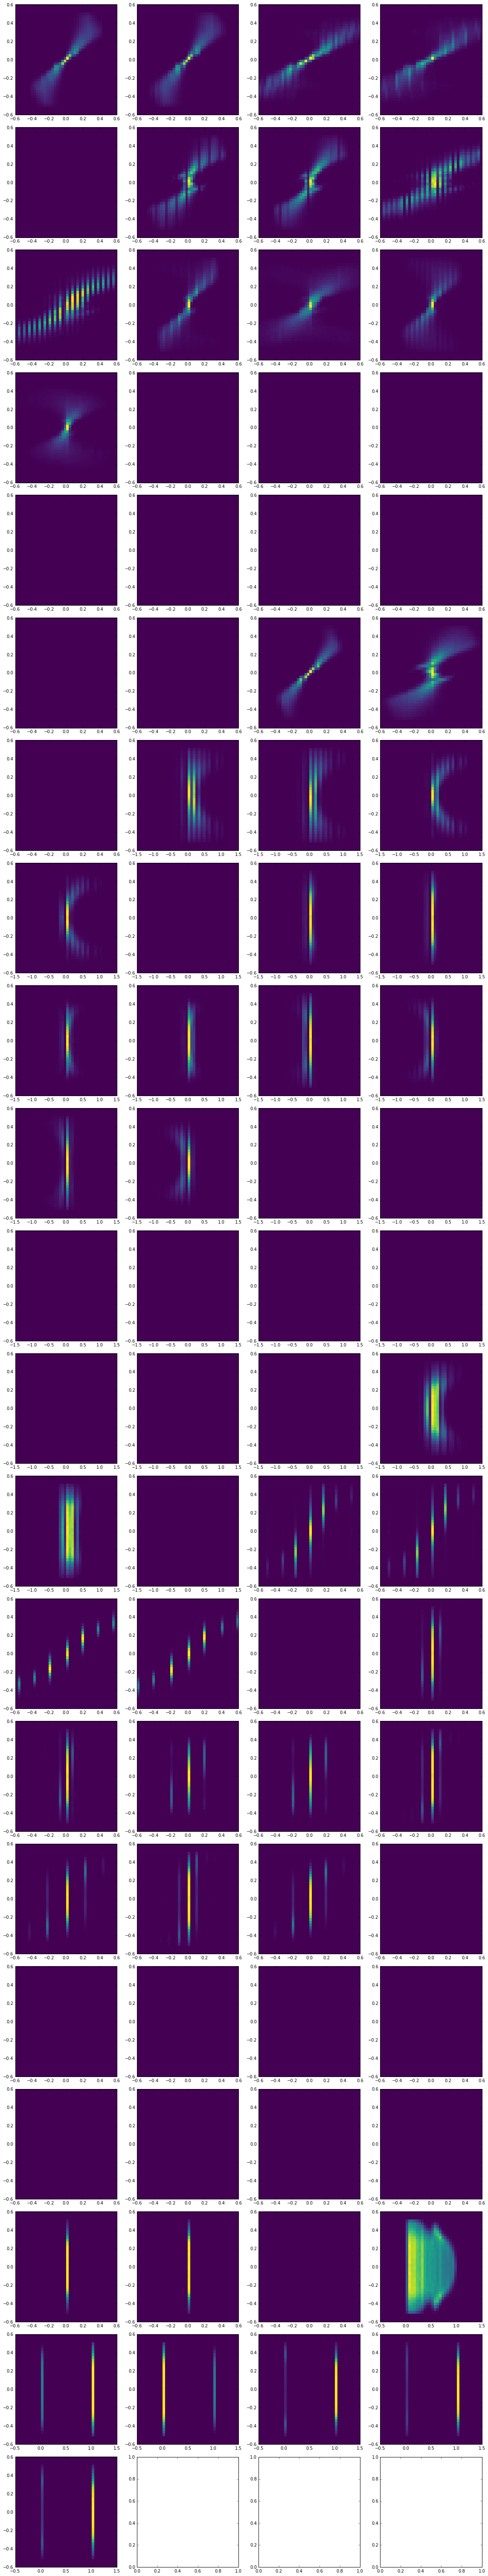

In [11]:
if True:
  print x_train.shape, y_train.shape, x_mask_train.shape

  fig, axs = plt.subplots(84/4, 4, figsize=(4*4,4*84/4), tight_layout=True)

  for i in xrange(x_train.shape[1]):
    lay = (i % nlayers)
    mask = x_mask_train[...,lay].copy()
    if i >= (nlayers*3):
      mask *= False
    
    valid = ~mask
    x_i = x_train[valid,i]
    y_i = y_train[valid]

    #fig, ax = plt.subplots(tight_layout=True)
    xmin, xmax = -0.6, 0.6
    ymin, ymax = -0.6, 0.6
    if (nlayers) <= i < (nlayers*2):
      xmin, xmax = -1.5, 1.5
    elif i == 75:
      xmin, xmax = -0.5, 1.5
    elif 76 <= i < 81:
      xmin, xmax = -0.5, 1.5
    
    hist = axs[(i/4, i%4)].hist2d(x_i, y_i, bins=40, range=[[xmin, xmax], [ymin, ymax]], cmap=plt.cm.viridis)  #norm=colors.LogNorm(),
    if x_i.size > 0:
      print i, np.mean(x_i), np.std(x_i), np.percentile(x_i, [2,98])

In [12]:
class MoreChiSquare(object):  # this guy handles data after scaled
  
  def __init__(self, x, x_mask, y):
    
    self.nentries = 40000 * 3 * 15
    self.nvariables = (nlayers*3)
    #self.nvariables = (nlayers)
    
    self.x = x[:self.nentries, :self.nvariables]
    self.x_mask = x_mask[:self.nentries]
    self.y = y[:self.nentries]
    assert(self.x.shape[0] == self.x_mask.shape[0])
    assert(self.x.shape[0] == self.y.shape[0])
    
    theta_var = (nlayers*3) + 0
    self.x_theta_median = x[:self.nentries, theta_var]
    
    self.theta_bins = (10, 0.0, 1.0)
    self.pt_bins = (40, -0.2, 0.2)
    self.chsq_n1 = np.zeros((self.theta_bins[0], self.pt_bins[0], self.nvariables), dtype=np.int32)
    self.chsq_n2 = np.zeros((self.theta_bins[0], self.pt_bins[0], self.nvariables), dtype=np.int32)
    self.chsq_prob = np.zeros((self.theta_bins[0], self.pt_bins[0], self.nvariables), dtype=np.float32)
    self.chsq_prob_1 = np.zeros((self.theta_bins[0], self.pt_bins[0], self.nvariables), dtype=np.float32)
    self.chsq_offset = np.zeros((self.theta_bins[0], self.pt_bins[0], self.nvariables), dtype=np.float32)
    self.chsq_scale = np.ones((self.theta_bins[0], self.pt_bins[0], self.nvariables), dtype=np.float32)
    self.chsq_offset_1 = np.zeros((self.theta_bins[0], self.pt_bins[0], self.nvariables), dtype=np.float32)
    self.chsq_scale_1 = np.ones((self.theta_bins[0], self.pt_bins[0], self.nvariables), dtype=np.float32)
    self._find_difference()

  def _find_bin(self, x, bins):
    x = np.clip(x, bins[1], bins[2]-1e-8)
    binx = (x - bins[1]) / (bins[2] - bins[1]) * bins[0]
    return int(binx)

  def _find_theta_bin(self, theta):
    return self._find_bin(theta, self.theta_bins)

  def _find_pt_bin(self, pt):
    return self._find_bin(pt, self.pt_bins)

  def _find_difference(self):
    
    print('[INFO] Make bins for theta and pt')
    chsq_ipt = np.vectorize(self._find_pt_bin)(np.clip(self.y, self.pt_bins[1], self.pt_bins[2]))
    chsq_itheta = np.vectorize(self._find_theta_bin)(self.x_theta_median)
    
    for itheta, ipt in zip(chsq_itheta, chsq_ipt):
      self.chsq_n2[itheta,ipt] += 1
    
    for i in xrange(self.nvariables):
      print('[INFO] Find difference for var {0}'.format(i))

      lay = (i % nlayers)
      valid = ~self.x_mask[:,lay]
      x_i = self.x[:,i][valid]

      if x_i.size == 0:
        continue
      if x_i.size < 400:
        print('[WARNING] Not enough statistics: {0}'.format(x_i.size))

      #y_i = self.y[valid]
      #theta_i = self.x_theta_median[valid]
      
      chsq_ipt_i = chsq_ipt[valid]
      chsq_itheta_i = chsq_itheta[valid]
      
      print x_i.shape, chsq_itheta_i.shape, chsq_ipt_i.shape
      
      # Reuse the pattern technology
      patterns = np.empty((self.theta_bins[0], self.pt_bins[0]), dtype=np.object)
      for ind in np.ndindex(patterns.shape):
        patterns[ind] = []
      
      for itheta, ipt, x in zip(chsq_itheta_i, chsq_ipt_i, x_i):
        self.chsq_n1[itheta,ipt,i] += 1
        patterns[itheta,ipt].append(x)
    
      #print self.chsq_n1[...,i], self.chsq_n2[...,i]
      self.chsq_prob[...,i] = np.true_divide(self.chsq_n1[...,i], self.chsq_n2[...,i])

      for ind in np.ndindex(patterns.shape):
        if len(patterns[ind]) == 0:
          continue
        if len(patterns[ind]) < 40:
          print('[WARNING] Not enough statistics: {0} {1}'.format(ind, len(patterns[ind])))
          patterns[ind] = []
          continue
        
        ind2 = ind + (i,)
        prob = 100. - 50. * (1.0 - self.chsq_prob[ind2])
        
        p = np.percentile(patterns[ind], [25, 50, 75, prob], overwrite_input=True)
        patterns[ind] = p
      
      for ind in np.ndindex(patterns.shape):
        p = patterns[ind]
        if len(p) == 0:
          p = [-0.5, 0, 0.5, 0]
        assert(len(p) == 4)
        
        ind2 = ind + (i,)
        self.chsq_offset[ind2] = p[1]
        if p[2] > p[0]:
          self.chsq_scale[ind2] = 1.0 / (p[2] - p[0])
        else:
          self.chsq_scale[ind2] = 1.0
        self.chsq_prob_1[ind2] = p[3]
      
      smooth = True
      if smooth:
        from scipy.interpolate import Rbf
        x = [self.pt_bins[1] + (ipt+0.5)/self.pt_bins[0]*(self.pt_bins[2] - self.pt_bins[1]) for ipt in xrange(self.pt_bins[0])]
        for itheta in xrange(self.theta_bins[0]):
          assert(len(x) == len(self.chsq_offset[itheta,:,i]))
          rbf = Rbf(x, self.chsq_offset[itheta,:,i], smooth = 0.3, function='multiquadric')
          self.chsq_offset_1[itheta,:,i] = rbf(x)
          rbf = Rbf(x, self.chsq_scale[itheta,:,i], smooth = 0.3, function='multiquadric')
          self.chsq_scale_1[itheta,:,i] = rbf(x)


  def save_chsq(self, filepath):
    with np.load(chsqfile) as loaded:
      self.cov = loaded['cov']
      self.cov_1 = loaded['cov_1']
      self.cov_2 = loaded['cov_2']
      self.cov_3 = loaded['cov_3']
    np.savez_compressed(filepath, cov=self.cov, cov_1=self.cov_1, cov_2=self.cov_2, cov_3=self.cov_3, 
                        chsq_offset=self.chsq_offset, chsq_scale=self.chsq_scale, chsq_offset_1=self.chsq_offset_1, chsq_scale_1=self.chsq_scale_1,
                        chsq_prob=self.chsq_prob, chsq_prob_1=self.chsq_prob_1)

  def load_chsq(self, filepath):
    loaded = np.load(filepath)
    self.cov = loaded['cov']
    self.cov_1 = loaded['cov_1']
    self.cov_2 = loaded['cov_2']
    self.cov_3 = loaded['cov_3']
    self.chsq_offset = loaded['chsq_offset']
    self.chsq_scale = loaded['chsq_scale']
    self.chsq_offset_1 = loaded['chsq_offset_1']
    self.chsq_scale_1 = loaded['chsq_scale_1']
    self.chsq_prob = loaded['chsq_prob']
    self.chsq_prob_1 = loaded['chsq_prob_1']
    

In [13]:
chsq = MoreChiSquare(x_train, x_mask_train, y_train)
chsq.save_chsq('chsq_2GeV.npz')
print('[INFO] MoreChiSquare is saved as chsq_2GeV.npz')

[INFO] Make bins for theta and pt
[INFO] Find difference for var 0
(638942,) (638942,) (638942,)
[INFO] Find difference for var 1
(657954,) (657954,) (657954,)
[INFO] Find difference for var 2
(224931,) (224931,) (224931,)
[INFO] Find difference for var 3
(247963,) (247963,) (247963,)
[INFO] Find difference for var 4
[INFO] Find difference for var 5
(560678,) (560678,) (560678,)
[INFO] Find difference for var 6
(556878,) (556878,) (556878,)
[INFO] Find difference for var 7
(185836,) (185836,) (185836,)
[WARNING] Not enough statistics: (5, 17) 1
[WARNING] Not enough statistics: (5, 19) 1
[WARNING] Not enough statistics: (5, 20) 1
[WARNING] Not enough statistics: (5, 21) 2
[WARNING] Not enough statistics: (5, 22) 2
[INFO] Find difference for var 8
(211434,) (211434,) (211434,)
[WARNING] Not enough statistics: (5, 1) 11
[WARNING] Not enough statistics: (5, 2) 11
[WARNING] Not enough statistics: (5, 3) 9
[WARNING] Not enough statistics: (5, 4) 9
[WARNING] Not enough statistics: (5, 5) 5
[W

In [14]:
#print chsq.chsq_n1
#print chsq.chsq_n2
print chsq.chsq_prob
print chsq.chsq_prob_1
#print chsq.chsq_offset
#print chsq.chsq_scale
print chsq.chsq_offset_1
print chsq.chsq_scale_1
print np.where(chsq.chsq_scale<=0)
print np.where(chsq.chsq_scale_1<=0)

[[[ 0.47519284  0.53474236  0.         ...,  0.          0.8214286   0.        ]
  [ 0.51874292  0.494131    0.         ...,  0.          0.83301783  0.        ]
  [ 0.50725776  0.50137311  0.         ...,  0.          0.83954489  0.        ]
  ..., 
  [ 0.48584723  0.52384645  0.         ...,  0.          0.85459483  0.        ]
  [ 0.48485994  0.52573806  0.         ...,  0.          0.84254354  0.        ]
  [ 0.4643811   0.54666728  0.         ...,  0.          0.82433379  0.        ]]

 [[ 0.47311518  0.51586199  0.         ...,  0.43815768  0.57069838  0.        ]
  [ 0.51217467  0.49034426  0.         ...,  0.45871815  0.68150014  0.        ]
  [ 0.50371391  0.50151306  0.         ...,  0.45804676  0.6756534   0.        ]
  ..., 
  [ 0.50180304  0.49902913  0.         ...,  0.46879333  0.66907072  0.        ]
  [ 0.4930594   0.50721824  0.         ...,  0.46307606  0.67184895  0.        ]
  [ 0.4700613   0.51742423  0.         ...,  0.42317337  0.57298285  0.        ]]

 [[ 0.44

In [34]:
# Set to True to use the old file
if True:
  import shutil
  shutil.copyfile('../test2/chsq_2GeV.11.npz', chsqfile)
  #
  chsq.load_chsq(chsqfile)

(1886513, 81) (1886513,) (1886513, 25)
(1886513, 75) (1886513, 75)
0 0.00585677 0.8421 [-1.52380924  1.59649074]
1 0.0095381 0.830341 [-1.44999993  1.55555546]
2 0.00397711 0.819021 [-1.62499976  1.68421054]
3 0.00268135 0.829515 [-1.6785717   1.74999988]
5 -0.00753902 0.858111 [-1.75        1.61538446]
6 0.0164517 0.837921 [-1.62499988  1.60000002]
7 0.00759551 0.831966 [-1.62500012  1.64102578]
8 -0.00502961 0.812153 [-1.625       1.66666663]
9 -0.0153799 0.881454 [-1.95833337  1.83333313]
10 -0.0039357 0.875329 [-1.90476179  1.91666663]
11 0.00280436 0.843113 [-1.74999988  1.71052647]
12 -0.00197221 0.810877 [-1.66666663  1.62499988]
22 0.00141183 0.856333 [-1.56923079  1.61538494]
23 0.000520792 0.781622 [-1.48148131  1.43999994]
25 0.0249388 0.767571 [-1.5         1.75000012]
26 0.100782 0.798351 [-1.5  2. ]
27 0.150471 0.773168 [-1.33333337  2.        ]
28 0.0511765 0.70547 [-1.25  2.  ]
30 0.0352541 0.518852 [-1.  1.]
31 -0.0115845 0.206778 [-0.16666667  0.08333334]
32 0.156587 

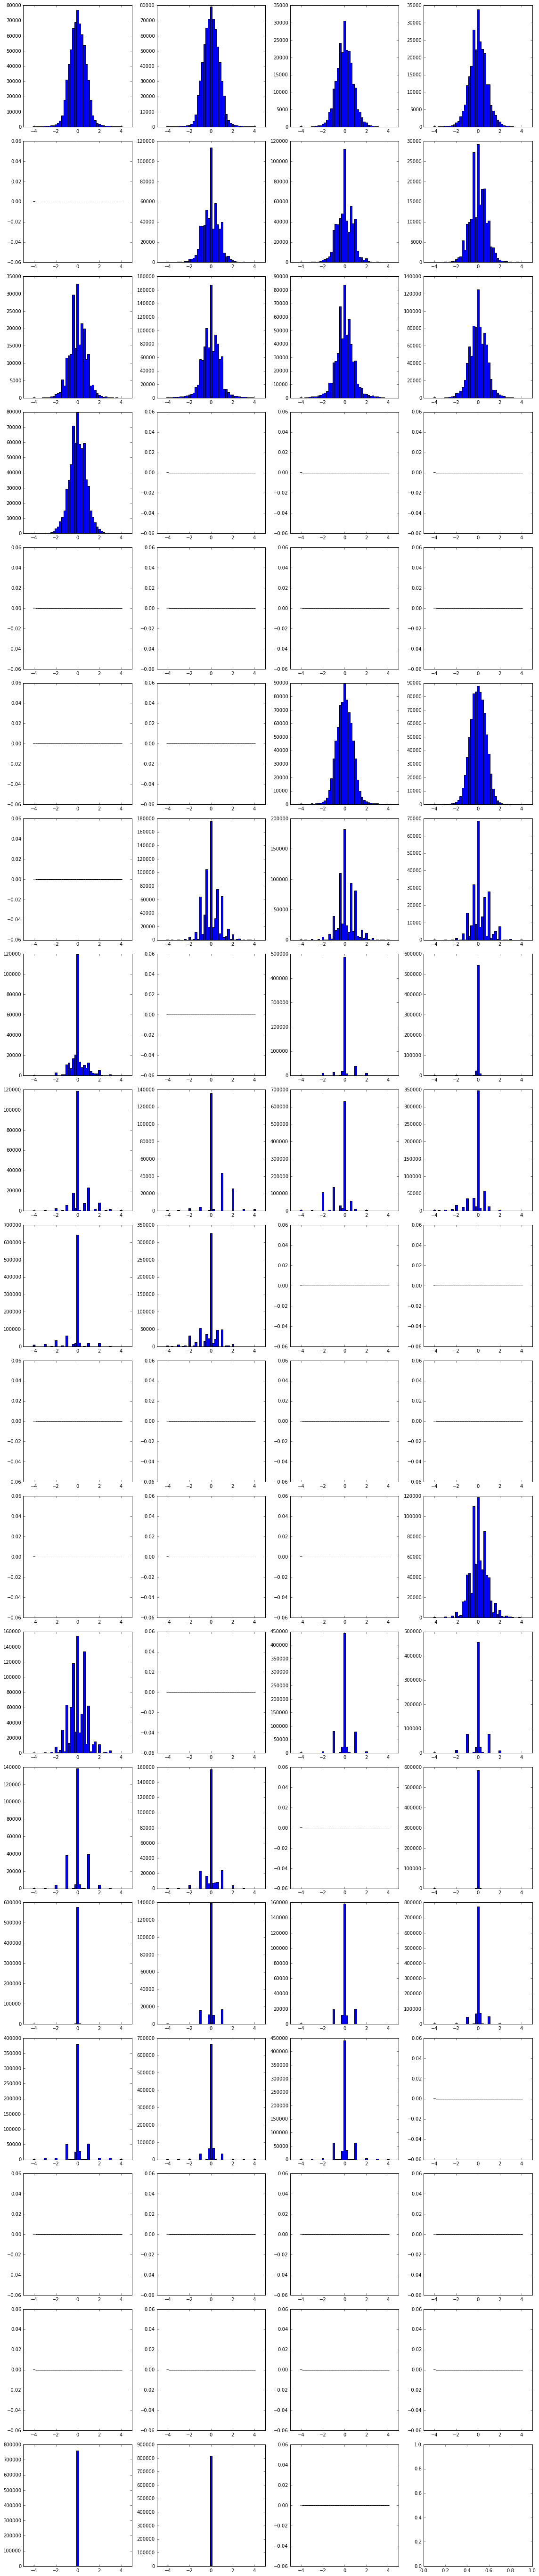

In [35]:
if True:
  print x_train.shape, y_train.shape, x_mask_train.shape
  
  nvariables = (nlayers*3)
  theta_var = (nlayers*3) + 0
  x_theta_median_train = x_train[:, theta_var]
  
  #chsq_ipt = np.apply_along_axis(chsq._find_pt_bin, 0, np.clip(y_train, chsq.pt_bins[1], chsq.pt_bins[2]))
  #chsq_itheta = np.apply_along_axis(chsq._find_theta_bin, 0, x_theta_median_train)
  chsq_ipt = np.vectorize(chsq._find_pt_bin)(np.clip(y_train, chsq.pt_bins[1], chsq.pt_bins[2]))
  chsq_itheta = np.vectorize(chsq._find_theta_bin)(x_theta_median_train)
  
  offset = chsq.chsq_offset[chsq_itheta, chsq_ipt]
  scale = chsq.chsq_scale[chsq_itheta, chsq_ipt]
  print offset.shape, scale.shape
  

  fig, axs = plt.subplots(76/4, 4, figsize=(4*4,4*76/4), tight_layout=True)

  for i in xrange(nvariables):
    lay = (i % nlayers)
    mask = x_mask_train[...,lay].copy()
    if i >= (nlayers*3):
      mask *= False
    
    valid = ~mask
    x_i = x_train[valid,i]
    y_i = y_train[valid]
    
    x_i -= offset[valid,i]
    x_i *= scale[valid,i]

    #fig, ax = plt.subplots(tight_layout=True)
    xmin, xmax = -4.1, 4.1
    hist = axs[(i/4, i%4)].hist(x_i, bins=41, range=[xmin, xmax])
    if x_i.size > 0:
      print i, np.mean(x_i), np.std(x_i), np.percentile(x_i, [2,98])

In [36]:
# minbias events
with np.load('histos_tbb_2GeV_add.npz') as data:
  minbias_variables = data['variables']
  minbias_predictions = data['predictions']  
  print minbias_variables.shape, minbias_predictions.shape
  
  dummy_1 = np.zeros(minbias_predictions.shape, dtype=np.float32) + 0
  dummy_2 = np.zeros(minbias_predictions.shape, dtype=np.float32) + 1.8
  minbias_predictions = np.hstack((minbias_predictions, dummy_1, dummy_2))
  
encoder = Encoder(minbias_variables, minbias_predictions, adjust_scale=2)
x_minbias, y_minbias, w_minbias, x_mask_minbias = encoder.get_x(), encoder.get_y(), encoder.get_w(), encoder.get_x_mask()

(68402, 104) (68402, 1)


/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/5.0-ghjeda6/lib/python2.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater


(68402, 81) (68402,) (68402, 25)
(68402, 75) (68402, 75)
0 0.0511107 2.05211 [-4.14285755  4.625     ]
1 0.0226801 2.14314 [-4.73073057  5.28000021]
2 0.0424227 2.11622 [-4.53899967  5.62500013]
3 -0.0481124 2.23273 [-5.00000021  4.80000006]
5 -0.0635232 2.05984 [-4.86807665  4.12857094]
6 -0.0717303 2.06141 [-5.14285707  4.        ]
7 0.0494194 2.64702 [-7.52000027  6.875     ]
8 0.165546 2.18906 [-5.35666695  5.96000004]
9 -0.0468725 1.94697 [-3.95238066  3.66666698]
10 -0.0669927 1.99379 [-5.10583363  3.51162839]
11 -0.00384894 2.17378 [-4.70833302  4.84490404]
12 0.023896 1.98719 [-3.94181489  4.375     ]
22 0.00443368 1.3988 [-1.78471031  1.68534178]
23 -0.0099653 2.2279 [-6.18181801  4.79333344]
25 0.146275 1.13128 [-2.          2.66666675]
26 0.105607 1.26413 [-2.74999976  3.        ]
27 0.446162 1.21771 [-1.00000012  4.        ]
28 0.444016 1.20779 [-1.  4.]
30 -0.00101025 1.076 [-3.  2.]
31 -0.0276698 0.288456 [-0.41666669  0.16666667]
32 0.238285 1.21997 [-2.  3.]
33 0.540601

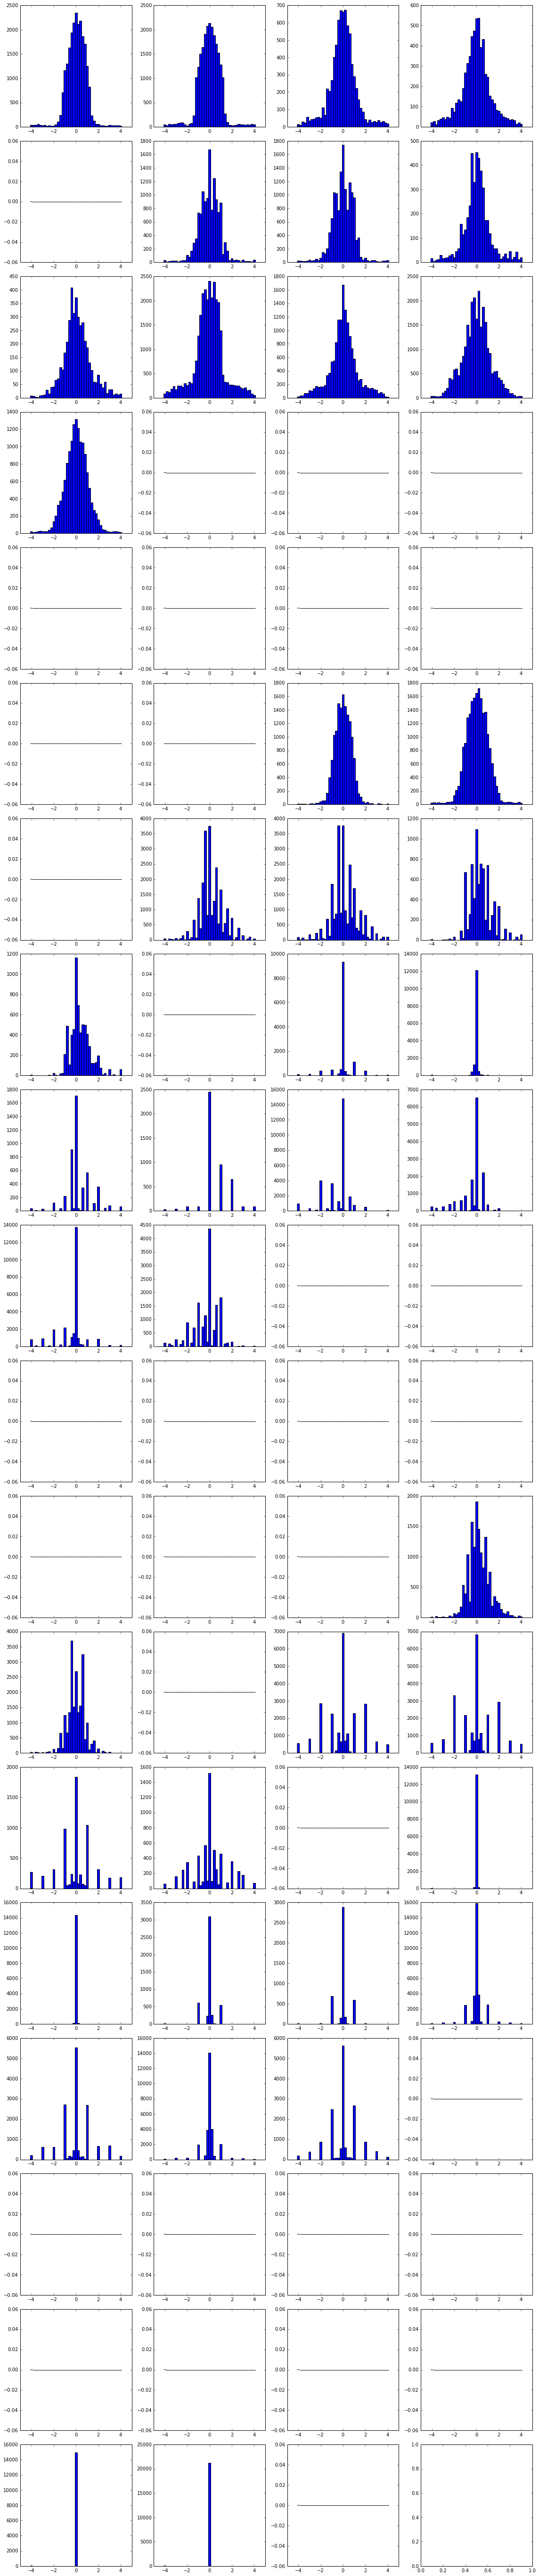

In [37]:
if True:
  print x_minbias.shape, y_minbias.shape, x_mask_minbias.shape
  
  nvariables = (nlayers*3)
  theta_var = (nlayers*3) + 0
  x_theta_median_minbias = x_minbias[:, theta_var]
  
  #chsq_ipt = np.apply_along_axis(chsq._find_pt_bin, 0, np.clip(y_minbias, chsq.pt_bins[1], chsq.pt_bins[2]))
  #chsq_itheta = np.apply_along_axis(chsq._find_theta_bin, 0, x_theta_median_minbias)
  chsq_ipt = np.vectorize(chsq._find_pt_bin)(np.clip(y_minbias, chsq.pt_bins[1], chsq.pt_bins[2]))
  chsq_itheta = np.vectorize(chsq._find_theta_bin)(x_theta_median_minbias)
  
  offset = chsq.chsq_offset[chsq_itheta, chsq_ipt]
  scale = chsq.chsq_scale[chsq_itheta, chsq_ipt]
  print offset.shape, scale.shape
  

  fig, axs = plt.subplots(76/4, 4, figsize=(4*4,4*76/4), tight_layout=True)

  for i in xrange(nvariables):
    lay = (i % nlayers)
    mask = x_mask_minbias[...,lay].copy()
    if i >= (nlayers*3):
      mask *= False
    
    valid = ~mask
    x_i = x_minbias[valid,i]
    y_i = y_minbias[valid]
    
    x_i -= offset[valid,i]
    x_i *= scale[valid,i]

    #fig, ax = plt.subplots(tight_layout=True)
    xmin, xmax = -4.1, 4.1
    hist = axs[(i/4, i%4)].hist(x_i, bins=41, range=[xmin, xmax])
    if x_i.size > 0:
      print i, np.mean(x_i), np.std(x_i), np.percentile(x_i, [2,98])

In [38]:
print x_mask_train[:10]

[[ True False  True  True  True False  True  True  True  True  True False
   True  True  True  True  True  True  True  True  True  True False  True
   True]
 [False  True  True  True  True  True False  True  True False  True False
   True  True  True  True  True  True  True  True  True  True  True  True
   True]
 [ True False  True  True  True  True  True  True  True False  True False
   True  True  True  True  True  True  True  True  True  True False  True
   True]
 [ True False  True  True  True False  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True]
 [ True  True  True  True  True  True  True False  True  True False  True
  False  True  True  True  True  True  True  True  True  True  True  True
   True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
  False  True  True  True  True  True  True  True  True  True  True  True
   True]
 [False  True  True  True  True False  True  True  True Fa

In [39]:
#### Application ####

import ROOT

ROOT.gROOT.LoadMacro("tdrstyle.C")
ROOT.gROOT.ProcessLine("setTDRStyle();")
ROOT.gStyle.SetPalette(57)  # kBird
ROOT.gStyle.SetPadGridX(True)
ROOT.gStyle.SetPadGridY(True)

h1a = ROOT.TEfficiency("effa", "effa", 50, 0, 100)
h1b = ROOT.TEfficiency("effb", "effb", 50, 0, 100)
h2a = ROOT.TH2F("h2a", "h2a", 13, 0, 13, 100, 0, 100)
h2b = ROOT.TH2F("h2b", "h2b", 13, 0, 13, 100, 0, 100)
n2a = []
n2b = []

layer_names = [
  "ME1/1f", "ME1/1r", "ME1/2f", "ME1/2r", "ME1/3", "ME2/1f", "ME2/1r", "ME2/2f", "ME2/2r", "ME3/1", "ME3/2", "ME4/1", "ME4/2",
  "RE1/2f", "RE1/2r", "RE2/2", "RE3/1", "RE3/2", "RE3/3", "RE4/1", "RE4/2", "RE4/3",
  "GE1/1", "GE2/1", "ME0",
]
layer_names = np.array(layer_names)


def calculate_chsq(x, x_mask, offset, scale, prob, delta=1.345):
  valid = ~x_mask
  valid = np.tile(valid,3)
  #valid[nlayers*1:nlayers*2] = False  # do not use thetas
  x -= offset
  x *= scale
  
  rpc_penalty = True
  if rpc_penalty:
    rpc_vars = np.zeros(nlayers, dtype=np.bool)
    rpc_vars[13:22] = True
    x[np.tile(rpc_vars,3)] *= 2
  
  x = x[valid]
  #x **= 2
  x = np.abs(x)
  x = np.where(x < delta, 0.5*np.square(x), delta * (x - 0.5*delta))
  chi2 = x.sum()
  ndof = (x_mask == False).sum()
  
  invalid = x_mask
  xx = prob.copy()
  xx -= offset
  xx *= scale
  xx = xx[:nlayers]
  xx = xx[invalid]
  xx = np.abs(xx)
  xx = np.where(xx < delta, 0.5*np.square(xx), delta * (xx - 0.5*delta))
  #xx = 0.5*np.square(xx)
  chi2_1 = xx.sum()
  #chi2 += 5 * chi2_1
  return (ndof, chi2, chi2_1, x)


#def simple_trigger(ndof, chi2):
#  assert(np.isfinite(chi2))
#  if 0 <= ndof <= 3:
#    return chi2 < 12.28219128
#  elif ndof == 4:
#    return chi2 < 12.82688751
#  elif ndof == 5:
#    return chi2 < 18.
#  elif ndof == 6:
#    return chi2 < 20.
#  elif ndof == 7:
#    return chi2 < 25.
#  elif ndof == 8:
#    return chi2 < 30.
#  else:
#    return chi2 < 75.

def simple_trigger(ndof, chi2):
  assert(np.isfinite(chi2))
  if 0 <= ndof <= 3:
    return chi2 < 7.5
  elif ndof == 4:
    return chi2 < 10.
  elif ndof == 5:
    return chi2 < 18.7
  elif ndof == 6:
    return chi2 < 21.5
  else:
    return chi2 < 35.

  
nvariables_to_scale = chsq.nvariables
nentries_test = 100000 * 4
x_copy = x_train[:nentries_test, :nvariables_to_scale].copy()
y_copy = y_train[:nentries_test].copy()

theta_var = (nlayers*3) + 0
theta_copy = x_train[:nentries_test, theta_var].copy()

x_mask_copy = x_mask_train[:nentries_test].copy()


# Loop over events
for i in xrange(nentries_test):
  x = x_copy[i]
  y = y_copy[i]
  theta = theta_copy[i]
  x_mask = x_mask_copy[i]
  
  #print x, y, theta, x_mask
  
  if np.abs(y) > 1.0/14:  # ignore less than 14 GeV tracks
    continue
  
  itheta = chsq._find_theta_bin(theta)
  ipt = chsq._find_pt_bin(y)
  offset = chsq.chsq_offset_1[itheta,ipt]
  scale = chsq.chsq_scale_1[itheta,ipt]
  prob = chsq.chsq_prob_1[itheta,ipt]
  
  (ndof, chi2, chi2_1, x) = calculate_chsq(x, x_mask, offset, scale, prob)
  
  h2a.Fill(ndof, chi2)
  n2a.append((ndof, chi2))
  
  trigger = simple_trigger(ndof, chi2)
  h1a.Fill(trigger, np.abs(1.0/y))
  
  if i < 40:
    print i, np.abs(1.0/y), ndof, chi2, chi2_1, layer_names[~x_mask], x


7 18.8988971444 4 0.973667 1.89335 ['ME1/2r' 'ME2/2r' 'ME3/2' 'ME4/2'] [  7.59651838e-03   4.16509316e-08   1.27887517e-01   5.01528144e-01
   2.07307088e-12   0.00000000e+00   2.36237543e-13   9.41979134e-13
   3.36654633e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00]
9 372.033028815 4 0.105806 2.58661 ['ME1/1f' 'ME2/1r' 'ME3/1' 'GE2/1'] [  1.05562270e-01   1.33800277e-05   2.36219639e-05   2.07057907e-04
   1.08083403e-11   0.00000000e+00   0.00000000e+00   4.75066709e-13
   1.44234983e-15   0.00000000e+00   0.00000000e+00   0.00000000e+00]
12 48.398997386 5 2.38196 0.639446 ['ME1/1f' 'ME2/1f' 'ME3/1' 'GE1/1' 'GE2/1'] [  7.07484633e-02   3.39919358e-01   4.77393597e-01   2.38290071e-01
   4.99626338e-01   4.99999106e-01   0.00000000e+00   4.95193608e-11
   1.25068262e-01   1.25000000e-01   2.38261650e-11   0.00000000e+00
   5.91693213e-03   0.00000000e+00   0.00000000e+00]
14 19.8431574543 3 1.50222 1.68703 ['ME2/2r' 'ME3/2' 'ME4/2'] [ 0.32879746  0.47363907  0.6997804   0. 

Warning in <TROOT::Append>: Replacing existing TH1: h2a (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2b (Potential memory leak).


In [40]:
#nvariables_to_scale = chsq.nvariables
nentries_test = x_minbias.shape[0]
x_copy = x_minbias[:nentries_test, :nvariables_to_scale].copy()
y_copy = y_minbias[:nentries_test].copy()

theta_var = (nlayers*3) + 0
theta_copy = x_minbias[:nentries_test, theta_var].copy()

x_mask_copy = x_mask_minbias[:nentries_test].copy()


# Loop over events
for i in xrange(nentries_test):
  x = x_copy[i]
  y = y_copy[i]
  theta = theta_copy[i]
  x_mask = x_mask_copy[i]
  
  #print x, y, theta, x_mask
  
  x_mode_vars = x_minbias[i, nlayers*3+1:nlayers*3+6]
  trk_mode = 0
  for i_mode_var, x_mode_var in enumerate(x_mode_vars):
    if i_mode_var == 0:
      station = 1
    else:
      station = i_mode_var
    if x_mode_var:
      trk_mode |= (1 << (4 - station))
  if trk_mode not in (11,13,14,15):  # single muon
    continue
  
  if np.abs(y) > 1.0/14:  # ignore less than 14 GeV tracks
    continue
  
  itheta = chsq._find_theta_bin(theta)
  ipt = chsq._find_pt_bin(y)
  offset = chsq.chsq_offset_1[itheta,ipt]
  scale = chsq.chsq_scale_1[itheta,ipt]
  prob = chsq.chsq_prob_1[itheta,ipt]
  
  (ndof, chi2, chi2_1, x) = calculate_chsq(x, x_mask, offset, scale, prob)
  
  h2b.Fill(ndof, chi2)
  n2b.append((ndof, chi2))
  
  trigger = simple_trigger(ndof, chi2)
  h1b.Fill(trigger, np.abs(1.0/y))
  
  if i < 400:
    print i, np.abs(1.0/y), ndof, chi2, chi2_1, layer_names[~x_mask], x
  

77 22.6024700967 5 8.54511 4.17353 ['ME1/1f' 'ME2/1f' 'ME3/1' 'ME4/1' 'GE1/1'] [ 5.11320829  0.07997237  0.61596149  0.36484793  0.43283275  0.22317423
  0.01388681  0.          0.          1.59226954  0.10332851  0.          0.
  0.00562987  0.        ]
184 25.4147463505 5 2.53389 0.854898 ['ME1/1r' 'ME2/1f' 'ME3/2' 'ME4/2' 'GE1/1'] [  1.15522139e-01   3.65891367e-01   6.13557994e-01   6.20563805e-01
   9.31914896e-02   1.87025920e-01   4.99950409e-01   3.47178220e-03
   3.46757099e-03   3.12491246e-02   6.78145803e-11   0.00000000e+00
   0.00000000e+00   1.59183105e-13   0.00000000e+00]
225 20.8593764072 3 30.9837 3.05498 ['ME1/1f' 'ME2/1f' 'ME4/1'] [  3.00076866e+00   1.30253944e+01   1.49251642e+01   1.30665465e-10
   0.00000000e+00   1.38888573e-02   1.28412005e-02   0.00000000e+00
   5.63050620e-03]
229 165.965560049 3 24.3346 2.48729 ['ME1/2f' 'ME2/2f' 'ME3/2'] [  1.73624024e-01   7.69055176e+00   1.16674891e+01   4.50613022e+00
   0.00000000e+00   6.56051751e-14   6.35494962e-0

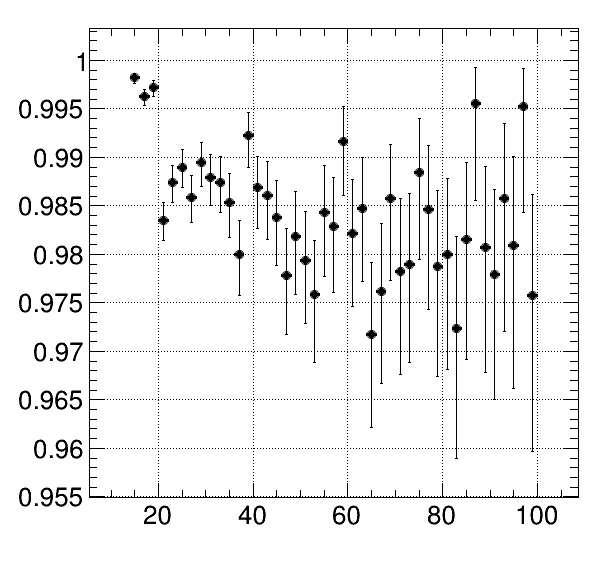

In [41]:
c = ROOT.TCanvas()
h1a.Draw("ap")
c.Draw()

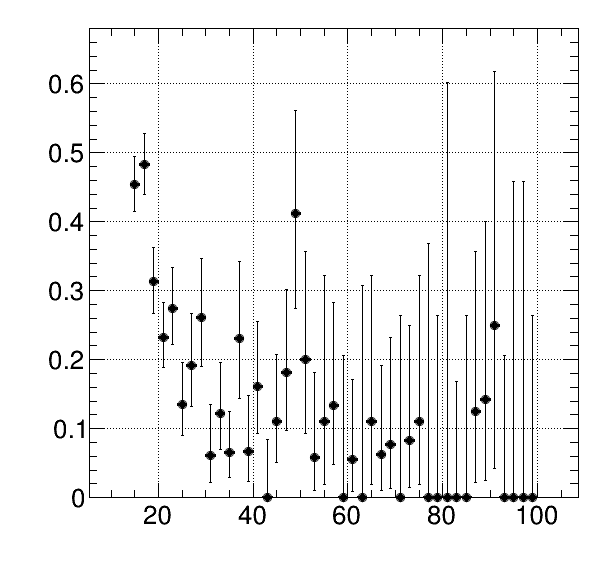

In [42]:
c = ROOT.TCanvas()
h1b.Draw("ap")
c.Draw()

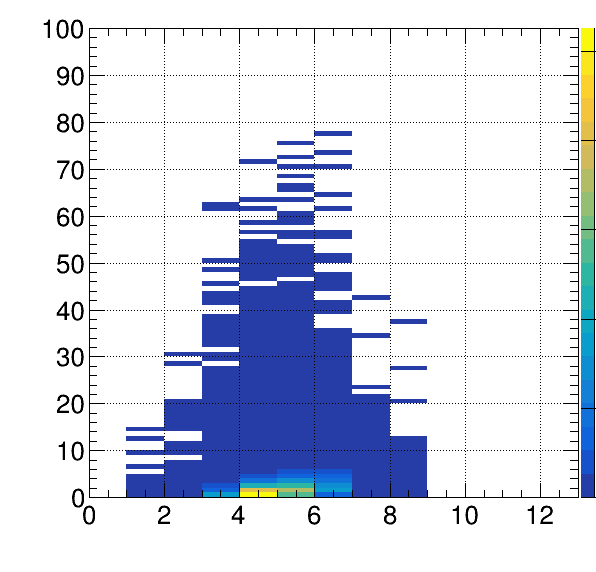

In [43]:
c = ROOT.TCanvas()
h2a.Draw("COLZ")
c.Draw()

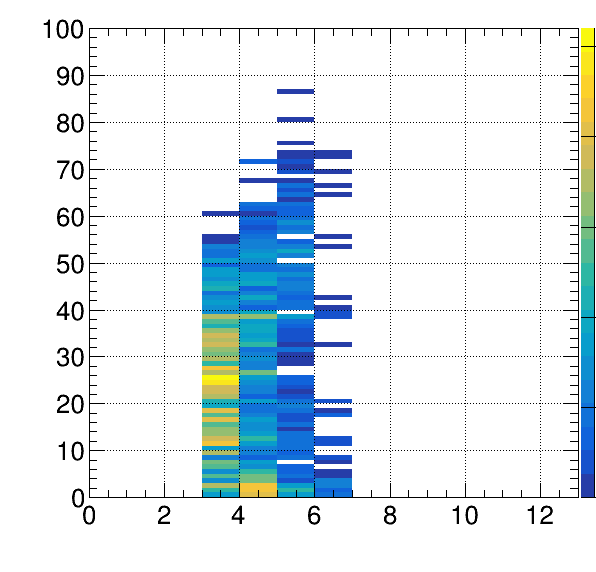

In [44]:
c = ROOT.TCanvas()
h2b.Draw("COLZ")
c.Draw()

(71992, 2) (1526, 2)
0 0 0
1 29 0
2 542 0
3 6303 709
4 27761 501
5 23778 268
6 12486 48
7 952 0
8 141 0
9 0 0
10 0 0
11 0 0
12 0 0
0 [  3.00778365   3.49365655   4.17602646   4.83897748   5.8069696
   7.08330909   7.82003652   9.60669308  15.7072877   23.57880353]
0 6874 709
1 [  3.76099372   4.20699787   4.87437258   5.40748644   6.19567127
   7.33630953   8.27089024   9.55013351  14.67439117  22.85472183]
1 27761 501
2 [  4.81866341   5.3907362    6.26571011   6.93372734   8.12252071
   9.8952807   11.32023437  13.20746902  19.27255119  28.14473535]
2 23778 268
3 [  5.99288177   6.56610231   7.44252825   8.12462091   9.37061195
  11.13667736  12.53455877  14.24311399  21.13567171  27.27634511]
3 12486 48
4 [  7.44886856   8.03198856   8.89171721   9.63324723  10.69109978
  12.121169    13.17939107  14.23386707  18.72781416  20.49482741]
4 952 0


/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/5.0-ghjeda6/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


5 [  9.40382195   9.84986267  10.23062763  10.53071976  11.83362808
  12.76508408  16.54035902  21.53266296  33.29620438  58.2028019 ]
5 141 0
6

IndexError: cannot do a non-empty take from an empty axes.

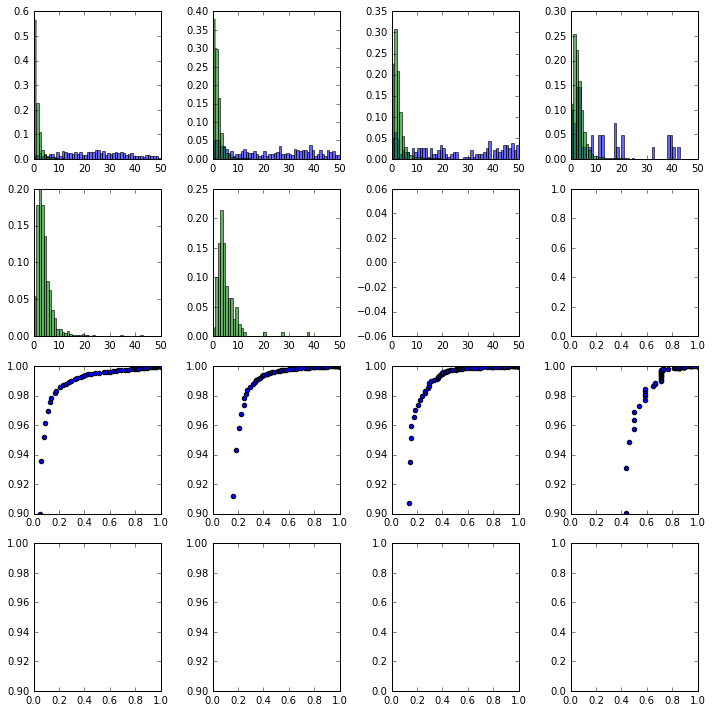

In [45]:
n2a = np.asarray(n2a)
n2b = np.asarray(n2b)

print n2a.shape, n2b.shape
for i in xrange(13):
  print i, len(n2a[n2a[:,0] == i]), len(n2b[n2b[:,0] == i])

  
fig, axs = plt.subplots(4, 4, figsize=(5*2,5*2), tight_layout=True)

for i in xrange(8):
  if i == 0:
    ind_a = (0 <= n2a[:,0]) & (n2a[:,0] < 4)
    ind_b = (0 <= n2b[:,0]) & (n2b[:,0] < 4)
  elif i == 7:
    ind_a = (10 <= n2a[:,0]) & (n2a[:,0] < 16)
    ind_b = (10 <= n2b[:,0]) & (n2b[:,0] < 16)
  else:
    ind_a = ((i+3) <= n2a[:,0]) & (n2a[:,0] < (i+4))
    ind_b = ((i+3) <= n2b[:,0]) & (n2b[:,0] < (i+4))  

  xmin, xmax = 0., 50.
  hist = axs[(i/4, i%4)].hist(n2b[ind_b,1], bins=50, range=[xmin, xmax], alpha=0.6, normed=True)
  hist = axs[(i/4, i%4)].hist(n2a[ind_a,1], bins=50, range=[xmin, xmax], alpha=0.6, normed=True)
  
  print i, np.percentile(n2a[ind_a,1], [90, 92, 94, 95, 96, 97, 97.5, 98, 99, 99.5], overwrite_input=True)
  
  # ROC
  sig = np.clip(np.sort(n2a[ind_a,1]), 0., 99.)
  bkg = np.clip(np.sort(n2b[ind_b,1]), 0., 99.)
  nsig = len(sig)
  nbkg = len(bkg)
  print i, nsig, nbkg
  
  sig_cut = sig[:,np.newaxis] < np.linspace(1,100,100)
  bkg_cut = bkg[:,np.newaxis] < np.linspace(1,100,100)
  #print sig_cut.shape, bkg_cut.shape
  
  sig_eff = np.sum(sig_cut, axis=0)
  bkg_eff = np.sum(bkg_cut, axis=0)
  #print sig_eff.shape, bkg_eff.shape
  
  sig_eff = np.true_divide(sig_eff, nsig)
  bkg_eff = np.true_divide(bkg_eff, nbkg)
  #print sig_eff
  #print bkg_eff
  
  j = i + 8
  scat = axs[(j/4, j%4)].scatter(bkg_eff, sig_eff)
  axs[(j/4, j%4)].set_xlim(0, 1)
  axs[(j/4, j%4)].set_ylim(0.9, 1)


In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


X = np.vstack((n2a, n2b))
y_a = np.ones((n2a.shape[0],1), dtype=np.float32)
y_b = np.zeros((n2b.shape[0],1), dtype=np.float32)
y = np.vstack((y_a, y_b))[:,0]

#X = np.vstack((n2a[:10000], n2b[:10000]))
#y_a = np.ones((n2a.shape[0],1), dtype=np.float32)
#y_b = np.zeros((n2b.shape[0],1), dtype=np.float32)
#y = np.vstack((y_a[:10000], y_b[:10000]))[:,0]

print('[INFO] Start training.')
#clf = SVC(kernel='linear', C=0.5)
#clf = SVC(kernel='rbf', gamma=0.7, C=1.0)
#clf = SVC(kernel='poly', degree=3, C=1.0)
clf = RandomForestClassifier(max_depth=3, n_estimators=50, max_features=1)
clf = clf.fit(X,y)
print('[INFO] Done training.')

fig, ax = plt.subplots(tight_layout=True, figsize=(6,6))

X0, X1 = X[:, 0], X[:, 1]
xx, yy = np.meshgrid(np.linspace(0,13,14), np.linspace(0,100,51))

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)

ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())


In [ ]:
########################## PLEASE IGNORE